Fantasy Football Machine Learning Project

Pt.1 Load Data from fantasypros.com

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge


years = range(2013, 2024)
qb_df = []

# need to do each position individually
for year in years:
    html = f"https://www.fantasypros.com/nfl/stats/qb.php?year={year}&scoring=PPR&range=full"
    df = pd.read_html(html, header=1)[0]
    df['Year'] = year  # Add a 'Year' column with the current year
    df['Position'] = "QB"  # Add a 'Position' column       
    qb_df.append(df)

# Combine all qb DataFrames into one
qb_df_combined = pd.concat(qb_df, ignore_index=True)
selected_columns = [
    'Player', 'CMP','ATT','PCT','YDS', 'TD', 'INT', 'SACKS',
    'ATT.1', 'YDS.1', 'TD.1',
    'FL','FPTS/G', 'Year', 'Position'
]

qb_df_combined = qb_df_combined[selected_columns]
qb_df_combined.rename(columns={
    'CMP':'Completions','ATT':'Passing Attempts','PCT':'Completion_Percentage','YDS':'Passing_Yards', 'TD':'Passing_TDs', 'INT':'Interceptions', 'SACKS':'Sacks',
    'ATT.1':'Rushing_Attempts', 'YDS.1':'Rushing_Yards', 'TD.1':'Rushing_TDs',
    'FL':'Fumbles_Lost'
    }, inplace=True)

#RBs

rb_df = []
for year in years:
    html = f"https://www.fantasypros.com/nfl/stats/rb.php?year={year}&scoring=PPR&range=full"
    df = pd.read_html(html, header=1)[0]
    df['Year'] = year  # Add a 'Year' column with the current year
    df['Position'] = "RB"  # Add a 'Position' column       
    rb_df.append(df)

# Combine all rb DataFrames into one
rb_df_combined = pd.concat(rb_df, ignore_index=True)
selected_columns = [
    'Player', 'ATT', 'YDS', 'Y/A', 'LG', '20+' ,'TD' , 
    'REC' , 'TGT', 'YDS.1', 'Y/R', 'TD.1',
    'FL','FPTS/G','Year','Position' 
]

rb_df_combined = rb_df_combined[selected_columns]
rb_df_combined.rename(columns={
    'ATT':'Rushing_Attempts', 'YDS':'Rushing_Yards', 'Y/A':'Yards_Per_Rush', 'LG':'Longest_Play', '20+':'20_Yard_Plays' ,'TD':'Rushing_TDs' , 
    'REC':'Receptions' , 'TGT':'Targets', 'YDS.1':'Receiving_Yards', 'Y/R':'Yards_Per_Reception', 'TD.1':'Receiving_TDs',
    'FL':'Fumbles_Lost'
    }, inplace=True)

#WRs

wr_df = []
for year in years:
    html = f"https://www.fantasypros.com/nfl/stats/wr.php?year={year}&scoring=PPR&range=full"
    df = pd.read_html(html, header=1)[0]
    df['Year'] = year  # Add a 'Year' column with the current year
    df['Position'] = "WR"  # Add a 'Position' column       
    wr_df.append(df)

# Combine all wr DataFrames into one
wr_df_combined = pd.concat(wr_df, ignore_index=True)
selected_columns = [
    'Player','REC', 'TGT', 'YDS', 'Y/R', 'LG', '20+' ,'TD' , 
    'ATT' , 'YDS.1', 'TD.1',
    'FL','FPTS/G','Year','Position' 
]

wr_df_combined = wr_df_combined[selected_columns]
wr_df_combined.rename(columns={
    'REC':'Receptions' , 'TGT':'Targets', 'YDS':'Receiving_Yards', 'Y/R':'Yards_Per_Reception', 'LG':'Longest_Play', '20+':'20_Yard_Plays' ,'TD':'Receiving_TDs' ,
    'ATT':'Rushing_Attempts', 'YDS.1':'Rushing_Yards', 'TD.1':'Rushing_TDs' , 
    'FL':'Fumbles_Lost'
    }, inplace=True)

#TEs
te_df = []
for year in years:
    html = f"https://www.fantasypros.com/nfl/stats/te.php?year={year}&scoring=PPR&range=full"
    df = pd.read_html(html, header=1)[0]
    df['Year'] = year  # Add a 'Year' column with the current year
    df['Position'] = "TE"  # Add a 'Position' column       
    te_df.append(df)

# Combine all rb DataFrames into one
te_df_combined = pd.concat(te_df, ignore_index=True)
selected_columns = [
    'Player', 'REC', 'TGT', 'YDS', 'Y/R', 'LG', '20+' ,'TD' , 
    'ATT' , 'YDS.1', 'TD.1',
    'FL','FPTS/G','Year','Position' 
]

te_df_combined = te_df_combined[selected_columns]
te_df_combined.rename(columns={
    'REC':'Receptions' , 'TGT':'Targets', 'YDS':'Receiving_Yards', 'Y/R':'Yards_Per_Reception', 'LG':'Longest_Play', '20+':'20_Yard_Plays' ,'TD':'Receiving_TDs' ,
    'ATT':'Rushing_Attempts', 'YDS.1':'Rushing_Yards', 'TD.1':'Rushing_TDs' , 
    'FL':'Fumbles_Lost'
    }, inplace=True)

combined_df = pd.concat([qb_df_combined,wr_df_combined,rb_df_combined,te_df_combined], ignore_index=True)


Ridge regression



In [61]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression,ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd

predictions_list = []


for player in combined_df['Player'].unique():
    player_data = combined_df[combined_df['Player'] == player]
    player_data = player_data.sort_values(by='Year')
    player_data = player_data.dropna(axis=1,how='any')
    most_recent_position = player_data.iloc[-1]['Position']
    feature_columns = [col for col in player_data.columns if col not in ['Player', 'Year', 'FPTS/G','Position']]

    for year in range(player_data['Year'].min() + 1, player_data['Year'].max() + 1):
        train_data = player_data[player_data['Year'] < year]
        test_data = player_data[player_data['Year'] == year]
        
        if len(train_data) > 1 and not test_data.empty:
            
            scaler = StandardScaler()

            X_train = train_data[feature_columns].iloc[:-1].values
            y_train = train_data['FPTS/G'].iloc[1:].values
            
            X_test = test_data[feature_columns].values
            y_test = test_data['FPTS/G'].values  # For evaluation

            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Fit the Ridge Regression model
            model = SVR(kernel='rbf')
            model.fit(X_train_scaled, y_train)
            
            predicted_FPPG = model.predict(X_test_scaled)
            predicted_FPPG = np.clip(predicted_FPPG, 0, None)  # Ensure predictions are non-negative
            
            for i, (index, row) in enumerate(test_data.iterrows()):
                predictions_list.append({
                    'Player': player,
                    'Position': most_recent_position,
                    'Year': year,
                    'Predicted_FPTS/G': predicted_FPPG[i],  # Directly access the ith prediction
                    'Actual_FPTS/G': row['FPTS/G']
                })

predictions_df = pd.DataFrame(predictions_list)


Lets compare against analyst predictions

In [62]:
positions = ['qb','wr','te','rb']
all_df = pd.DataFrame()
for position in positions:
    html = f"https://www.fantasypros.com/nfl/projections/{position}.php?week=draft&scoring=PPR"
    df = pd.read_html(html, header=1)[0]
    df = df[['Player','FPTS']]
    all_df = pd.concat([all_df, df], ignore_index=True)


all_df['Analyst Prediction'] = all_df['FPTS']/17

comp_df = predictions_df[predictions_df['Year'] == 2023].copy()
comp_df.loc[:, 'Player'] = comp_df['Player'].str.replace(r"\(", "", regex=True).str.replace(r"\)", "", regex=True)

predictions_analyst_combined = pd.merge(comp_df,all_df[['Player','Analyst Prediction']],
                                        on=['Player'],
                                        how='left')

# Calculate RMSE and MAE for the predictions

valid_predictions = predictions_analyst_combined.dropna(subset=['Analyst Prediction'])

my_rmse = np.sqrt(mean_squared_error(predictions_analyst_combined['Actual_FPTS/G'], predictions_analyst_combined['Predicted_FPTS/G']))
my_mae = mean_absolute_error(predictions_analyst_combined['Actual_FPTS/G'], predictions_analyst_combined['Predicted_FPTS/G'])

analyst_rmse = np.sqrt(mean_squared_error(valid_predictions['Actual_FPTS/G'], valid_predictions['Analyst Prediction']))
analyst_mae = mean_absolute_error(valid_predictions['Actual_FPTS/G'], valid_predictions['Analyst Prediction'])


print(f'My RMSE: {my_rmse}')
print(f'My MAE: {my_mae}')
print(f'Analyst RMSE: {analyst_rmse}')
print(f'Analyst MAE: {analyst_mae}')

My RMSE: 4.29973954412877
My MAE: 2.9593025222419795
Analyst RMSE: 2.8404827433685935
Analyst MAE: 1.7140976098468585


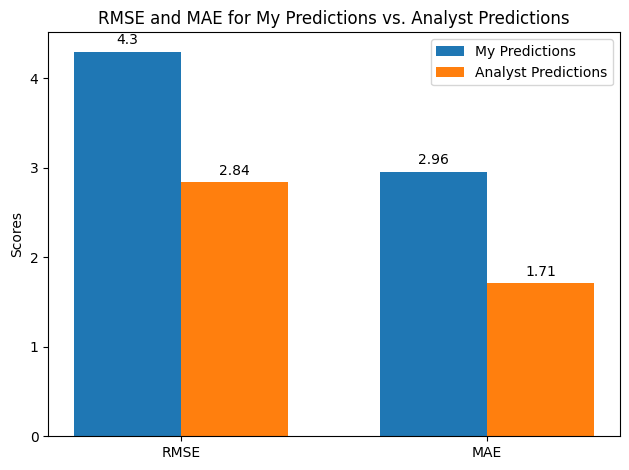

In [63]:
import matplotlib.pyplot as plt

# Assuming analyst_rmse, analyst_mae, my_rmse, and my_mae are already defined as per your previous calculations

# Metrics to plot
metrics = ['RMSE', 'MAE']
my_metrics = [my_rmse, my_mae]
analyst_metrics = [analyst_rmse, analyst_mae]

# Setting up the plot
x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, my_metrics, width, label='My Predictions')
rects2 = ax.bar(x + width/2, analyst_metrics, width, label='Analyst Predictions')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('RMSE and MAE for My Predictions vs. Analyst Predictions')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Function to auto-label the bars with their height values for better readability
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

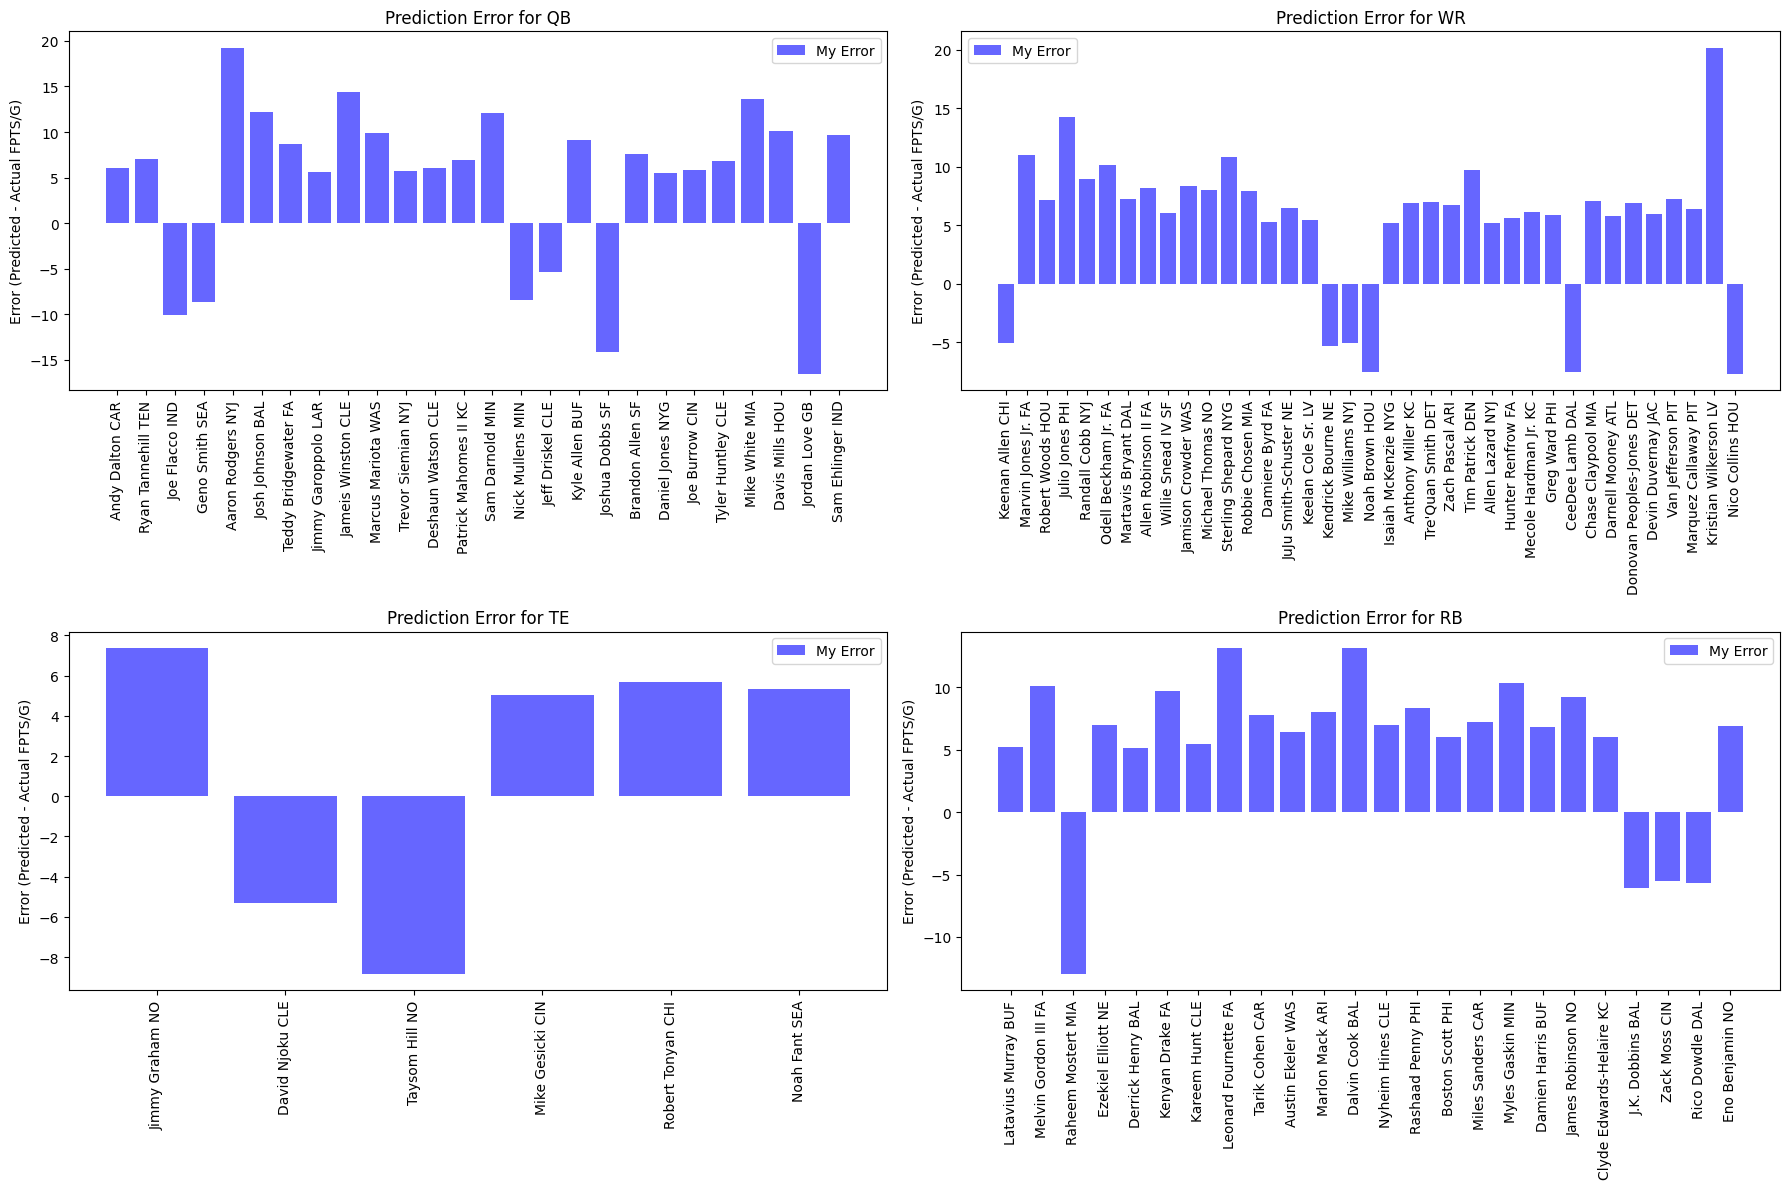

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Filter to include only rows where your absolute error is greater than 5
significant_errors = predictions_analyst_combined[
    abs(predictions_analyst_combined['My Error']) > 5
]

# Define positions
positions = ['QB', 'WR', 'TE', 'RB']

# Setting up the figure for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
axs = axs.flatten()  # Flatten the array to easily iterate over it

for i, position in enumerate(positions):
    # Filter the significant_errors DataFrame for the current position
    df_position = significant_errors[significant_errors['Position'] == position]
    
    # Number of players with significant errors in the current position
    n_players = len(df_position)
    ind = np.arange(n_players)  # the x locations for the groups

    # Plotting My Error for the current position
    axs[i].bar(ind, df_position['My Error'], label='My Error', alpha=0.6, color='blue')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs[i].set_ylabel('Error (Predicted - Actual FPTS/G)')
    axs[i].set_title(f'Prediction Error for {position}')
    axs[i].set_xticks(ind)
    axs[i].set_xticklabels(df_position['Player'], rotation=90)
    axs[i].legend()

plt.tight_layout()
plt.show()
